# Modelo de correlación QoE - NP para la gestión de QoS



### Importar librerías

In [130]:
# Análisis de los datos 
import csv
import pandas as pd
import numpy as np
import random as rnd #utilizada para obtener números aleatorios

# Visualización de los datos 

import seaborn as sns
import matplotlib.pyplot as plt

#scikit-Learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import tree


%matplotlib inline


### Lectura de los datos

In [131]:
#Access Points
client_df = pd.read_csv('DIT Client.csv') 
client_traffic_df = pd.read_csv('DIT Client Traffic.csv')
traffic_df = pd.read_csv('DIT AP Traffic.csv')
traffic_class_df = pd.read_csv('DIT AP Traffic Class.csv')

#Encuestas
encuestas_df = pd.read_excel('ALL_DIT_WiFi Quality Survey.xlsx')

### Filtrado fechas encuestas con DIT Client

A continuación, se obtendrán las fechas en la que los clientes realizarón sus encuestas para filtrarlo en DIT_client (client_df) 

In [132]:
client_df

,client_id,client_mac,updated_at,created_at
0,640,00:27:10:xx:xx:b8,2018-05-26 15:11:13,2015-01-31 08:07:50
1,848,78:7e:61:xx:xx:fa,2018-05-28 10:27:36,2015-02-05 08:36:45
2,932,d8:96:95:xx:xx:3d,2018-05-23 08:51:27,2015-02-06 17:13:47
3,985,20:c9:d0:xx:xx:5d,2018-05-29 16:11:27,2015-02-08 14:41:39
4,1038,a4:db:30:xx:xx:21,2018-05-29 18:01:45,2015-02-10 09:45:25
...,...,...,...,...
4671,571990,24:0d:c2:xx:xx:8c,2018-05-30 11:16:13,2018-05-30 11:14:54
4672,571991,24:18:1d:xx:xx:b6,2018-05-30 11:16:14,2018-05-30 11:16:14
4673,571992,30:10:b3:xx:xx:02,2018-05-30 11:17:14,2018-05-30 11:17:14
4674,571993,64:db:43:xx:xx:f3,2018-05-30 11:17:54,2018-05-30 11:17:18


In [133]:
fechas_encuestas = pd.DataFrame()
fechas_encuestas['Start Date'] = encuestas_df['Start Date']
#eliminamos primera fila, ya que no contiene información relevante
fechas_encuestas = fechas_encuestas.drop([0], axis=0)
#Obtenemos la fecha máxima y la fecha mínima
fecha_max = fechas_encuestas["Start Date"].max()
fecha_min = fechas_encuestas["Start Date"].min()

print("La fecha máxima es ", fecha_max )
print("La fecha mínima es ", fecha_min )

La fecha máxima es  2018-05-24 15:00:51
La fecha mínima es  2018-05-03 00:48:51


In [134]:
#Como los datos de la columna 'created_at' son de tipo string, en necesario pasarlo a formato datetime
client_df['created_at'] = pd.to_datetime(client_df['created_at'])
 #que hacer con updated_at??
#se elimina la columna de client_mac
client_nuevo = client_df.drop(['client_mac'], axis = 1)

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# FILTRADO DE LAS FECHAS
client_df_filtrado = client_nuevo[(client_nuevo['created_at'] >= fecha_min) & (client_nuevo['created_at'] < fecha_max)]
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
#Contabilización de registros
reg_nofi = len(client_nuevo.axes[0])
reg_fi = len(client_df_filtrado.axes[0])
print("registros sin el filtrado:", reg_nofi)
print("registros con el filtrado:", reg_fi)


registros sin el filtrado: 4676
registros con el filtrado: 3583


Con el filtrado se ha pasado de  4676 registros a 3583

### Filtrado de los clientes en DIT AP Cliente Traffic y filtrado de fechas

In [135]:
#Se almacenan los valores de los clients_id en un nuevo DataFrame
client_id = pd.DataFrame()
client_id['client_id'] = client_df_filtrado['client_id']
#se filtran los datos con dit_Client_traffic
client_traffic_filtrado = client_traffic_df[client_traffic_df['client_id'].isin(client_id['client_id'])]



client_traf = len(client_traffic_df.axes[0])
reg_traf_cli_fil = len(client_traffic_filtrado.axes[0])
print("Número de filas de tráfico de clientes sin filtrar:", client_traf)
print("Número de filas filtrando el tráfico de clientes (id_Client):", reg_traf_cli_fil)




Número de filas de tráfico de clientes sin filtrar: 44779
Número de filas filtrando el tráfico de clientes (id_Client): 37589


In [136]:
client_traffic_df.var()

/var/folders/r3/0qq4pc094kd5l8rzn5qsn__w0000gn/T/ipykernel_5473/1786447437.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  client_traffic_df.var()


client_traffic_id           1.425057e+09
client_id                   2.583334e+10
client_whitelist_id                  NaN
bssid_id                    2.705084e+06
ap_whitelist_id             3.546923e+01
monitor_radio_id            1.861206e+02
posted_data_id              6.064841e+10
channel                     3.487574e+02
managed_client              0.000000e+00
encrypted                   2.382816e-01
rss                         1.250126e+02
transmission_rate           3.413278e+02
reception_rate              1.173163e+03
bandwidth_economy_tx        4.687049e+03
bandwidth_economy_rx        2.263232e+04
throughput_tx               8.244439e-02
throughput_rx               9.959447e-02
frames_tx_data              3.188828e+05
frames_tx_fail_data         2.247388e+06
frames_rx_data              1.053442e+06
frames_rx_fail_data         5.448119e+08
frames_rx_mgnt              5.638933e+01
frames_rx_ctrl              4.840376e+05
fer_tx_data                          NaN
fer_rx_data     

In [137]:
#se filtran las fechas
fech = client_traffic_filtrado['created_at'][3]
type(fech)
##
# Se cambian los valores de created_at de str a DateTime 
client_traffic_filtrado1 = client_traffic_filtrado.copy()
client_traffic_filtrado1['created_at'] = pd.to_datetime(client_traffic_filtrado['created_at'])
##
#Filtrado por fechas
client_traffic_filtrado_fecha1 = client_traffic_filtrado1[(client_traffic_filtrado1['created_at'] >= fecha_min) & (client_traffic_filtrado1['created_at'] < fecha_max)]



In [138]:

#Comprobacion de registros
client_traf_ff = len(client_traffic_filtrado_fecha1.axes[0])
reg_traf_cli_fil = len(client_traffic_filtrado.axes[0])

print("Número de filas de tráfico de clientes sin filtrar:", client_traf)
print("Número de filas filtrando el tráfico de clientes (id_Client):", reg_traf_cli_fil)
print("Número de filas de tráfico de clientes filtrado con fecha:", client_traf_ff)

Número de filas de tráfico de clientes sin filtrar: 44779
Número de filas filtrando el tráfico de clientes (id_Client): 37589
Número de filas de tráfico de clientes filtrado con fecha: 21481


Número de filas de tráfico de clientes sin filtrar: 44779

Número de filas filtrando el tráfico de clientes (id_Client): 37589

Número de filas de tráfico de clientes filtrado con fecha: 21481

### Limpiado de datos

In [139]:
#traffic_cli_lim = client_traffic_filtrado_fecha1[['ssid','channel','transmission_rate','reception_rate','bandwidth_economy_tx']].copy()
traffic_cli_lim = client_traffic_filtrado_fecha1[['ssid','channel','transmission_rate','reception_rate','bandwidth_economy_tx','bandwidth_economy_rx','throughput_tx','throughput_rx','frames_tx_data','frames_tx_fail_data','frames_rx_data','frames_rx_fail_data','bytes_rx_data','created_at']].copy()


In [140]:
#varianza
traffic_cli_lim.var()

/var/folders/r3/0qq4pc094kd5l8rzn5qsn__w0000gn/T/ipykernel_5473/1529222667.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  traffic_cli_lim.var()


channel                 3.669006e+02
transmission_rate       3.749447e+02
reception_rate          1.210317e+03
bandwidth_economy_tx    6.157785e+03
bandwidth_economy_rx    3.028799e+04
throughput_tx           1.854618e-03
throughput_rx           1.326168e-01
frames_tx_data          3.614300e+05
frames_tx_fail_data     2.144070e+06
frames_rx_data          1.072624e+06
frames_rx_fail_data     7.758879e+08
bytes_rx_data           2.732944e+12
dtype: float64

### Tratamiento datos encuestas

In [141]:
encuestas_lim = pd.DataFrame()
encuestas_lim = encuestas_df[['Start Date','Rate the general quality experienced when using this WiFi network1.','Has the WiFi connection, in general, met your requirements and expectations?','Would you be happy to use this WiFi network again?']]
encuestas_lim.head()

,Start Date,Rate the general quality experienced when using this WiFi network1.,"Has the WiFi connection, in general, met your requirements and expectations?",Would you be happy to use this WiFi network again?
0,NaT,Rated,Response,Response
1,2018-05-03 11:33:55,4,5,5
2,2018-05-03 10:51:49,1,1,2
3,2018-05-03 09:56:48,2,3,4
4,2018-05-03 03:42:44,2,3,4


In [142]:

encuestas_lim = encuestas_lim.drop([0], axis=0)
encuestas_lim.var()


/var/folders/r3/0qq4pc094kd5l8rzn5qsn__w0000gn/T/ipykernel_5473/1102369965.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  encuestas_lim.var()


Rate the general quality experienced when using this WiFi network1.             0.991841
Has the WiFi connection, in general, met your requirements and expectations?    1.040460
Would you be happy to use this WiFi network again?                              1.006327
dtype: float64

In [143]:
encuestas_lim.columns = ['Start Date',
       'Rated Wifi QoE',
       'Requirements fulfilled',
       'Repeat']
encuestas_lim.head()

,Start Date,Rated Wifi QoE,Requirements fulfilled,Repeat
1,2018-05-03 11:33:55,4,5,5
2,2018-05-03 10:51:49,1,1,2
3,2018-05-03 09:56:48,2,3,4
4,2018-05-03 03:42:44,2,3,4
5,2018-05-03 01:17:30,4,3,3


In [144]:
traffic_cli_lim.head()


,ssid,channel,transmission_rate,reception_rate,bandwidth_economy_tx,bandwidth_economy_rx,throughput_tx,throughput_rx,frames_tx_data,frames_tx_fail_data,frames_rx_data,frames_rx_fail_data,bytes_rx_data,created_at
0,eduroam,64,24.991,104.459,27.0,170.2,0.000,0.013,78.0,2.0,117.0,21.0,49624.0,2018-05-18 10:11:22
1,eduroam,64,75.197,78.000,231.7,241.3,0.019,0.061,62.0,5.0,125.0,1.0,230413.0,2018-05-18 10:11:22
2,eduroam,64,24.000,0.000,26.3,0.0,0.000,0.000,1.0,0.0,0.0,0.0,0.0,2018-05-18 10:11:22
3,eduroam,64,61.183,65.000,115.3,183.4,0.004,0.007,102.0,0.0,53.0,0.0,26337.0,2018-05-18 10:11:22
4,ditwifi,64,24.000,0.000,26.3,0.0,0.000,0.000,1.0,0.0,0.0,0.0,0.0,2018-05-18 10:11:23


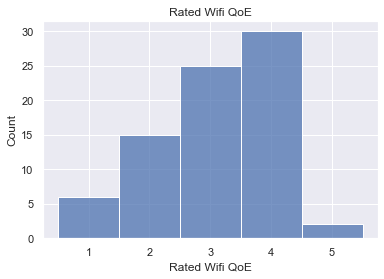

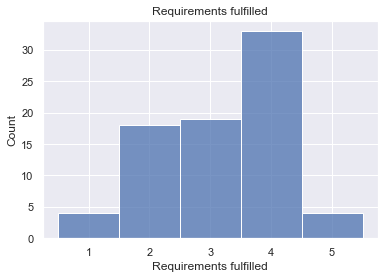

In [145]:
sns.set(style="darkgrid")
plt.title("Rated Wifi QoE")
sns.histplot( data = encuestas_lim, x = "Rated Wifi QoE", discrete=True)
plt.show()
plt.title("Requirements fulfilled")
sns.histplot( data = encuestas_lim, x = "Requirements fulfilled",discrete=True)
plt.show()


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='throughput_tx', ylabel='Density'>

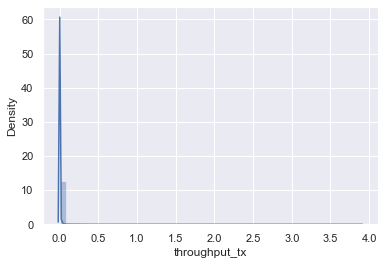

In [146]:
from seaborn import distplot
distplot(traffic_cli_lim.throughput_tx)

## Calculo de porcentajes en las encuestas

### Nueva columna con los datos de Rated QoE


A continuación, se obtendrá el porcentaje de los valores elegidos por los usuarios de la QoE

In [147]:
frecuencia_qoe = pd.DataFrame()
frecuencia_qoe['valores'] = encuestas_lim['Rated Wifi QoE'].value_counts(normalize=True)
frecuencia_qoe['rated'] = frecuencia_qoe.index
frecuencia_qoe = frecuencia_qoe.reindex(columns =['rated', 'valores'])
frecuencia_qoe=frecuencia_qoe.sort_values(by='rated')
frecuencia_qoe



,rated,valores
1,1,0.076923
2,2,0.192308
3,3,0.320513
4,4,0.384615
5,5,0.025641


Creamos nueva columna al dataframe Traffic_cli_lim y eliminamos los outliers

In [148]:
q_low = traffic_cli_lim["throughput_tx"].quantile(0.01)
q_hi  = traffic_cli_lim["throughput_tx"].quantile(0.99)

traffic_cli_lim = traffic_cli_lim[(traffic_cli_lim["throughput_tx"] < q_hi) & (traffic_cli_lim["throughput_tx"] > q_low)]

In [149]:
traffic_cli_lim['Rated'] = None
values = ["eduroam", "ditwifi"]
#values = ["ditwifi"]
#values = ["eduroam"]
traffic_cli_lim = traffic_cli_lim.drop(traffic_cli_lim[traffic_cli_lim['ssid']=="ditwifi"].index)
traffic_cli_lim = traffic_cli_lim.drop(traffic_cli_lim[traffic_cli_lim['ssid']=="eduroam"].index)
traffic_cli_lim

,ssid,channel,transmission_rate,reception_rate,bandwidth_economy_tx,bandwidth_economy_rx,throughput_tx,throughput_rx,frames_tx_data,frames_tx_fail_data,frames_rx_data,frames_rx_fail_data,bytes_rx_data,created_at,Rated
7924,eir16775415,3,1.071,NaN,NaN,NaN,0.001,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-22 06:14:48,None
7960,eir16775415,3,1.000,NaN,NaN,NaN,0.001,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-22 06:31:31,None
7972,STARBUCKS-FREE-WIFI,1,3.386,NaN,NaN,NaN,0.002,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-22 06:37:22,None
8063,eir92591853,4,1.223,NaN,NaN,NaN,0.003,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-22 07:18:27,None
8066,eir92591853,4,1.075,NaN,NaN,NaN,0.001,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-22 07:18:33,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22678,bell,8,59.916,NaN,NaN,NaN,0.001,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-24 13:37:18,None
22840,bell,8,45.853,NaN,NaN,NaN,0.003,0.007,NaN,NaN,NaN,NaN,NaN,2018-05-24 14:03:22,None
23117,RDCC_Guest,1,1.000,NaN,NaN,NaN,0.001,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-24 14:39:43,None
23167,RDCC_Guest,1,1.574,NaN,NaN,NaN,0.002,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-24 14:47:30,None


rellenamos los Datos NaN

In [150]:
traffic_cli_lim.fillna(0)

,ssid,channel,transmission_rate,reception_rate,bandwidth_economy_tx,bandwidth_economy_rx,throughput_tx,throughput_rx,frames_tx_data,frames_tx_fail_data,frames_rx_data,frames_rx_fail_data,bytes_rx_data,created_at,Rated
7924,eir16775415,3,1.071,0.0,0.0,0.0,0.001,0.000,0.0,0.0,0.0,0.0,0.0,2018-05-22 06:14:48,0
7960,eir16775415,3,1.000,0.0,0.0,0.0,0.001,0.000,0.0,0.0,0.0,0.0,0.0,2018-05-22 06:31:31,0
7972,STARBUCKS-FREE-WIFI,1,3.386,0.0,0.0,0.0,0.002,0.000,0.0,0.0,0.0,0.0,0.0,2018-05-22 06:37:22,0
8063,eir92591853,4,1.223,0.0,0.0,0.0,0.003,0.000,0.0,0.0,0.0,0.0,0.0,2018-05-22 07:18:27,0
8066,eir92591853,4,1.075,0.0,0.0,0.0,0.001,0.000,0.0,0.0,0.0,0.0,0.0,2018-05-22 07:18:33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22678,bell,8,59.916,0.0,0.0,0.0,0.001,0.000,0.0,0.0,0.0,0.0,0.0,2018-05-24 13:37:18,0
22840,bell,8,45.853,0.0,0.0,0.0,0.003,0.007,0.0,0.0,0.0,0.0,0.0,2018-05-24 14:03:22,0
23117,RDCC_Guest,1,1.000,0.0,0.0,0.0,0.001,0.000,0.0,0.0,0.0,0.0,0.0,2018-05-24 14:39:43,0
23167,RDCC_Guest,1,1.574,0.0,0.0,0.0,0.002,0.000,0.0,0.0,0.0,0.0,0.0,2018-05-24 14:47:30,0


### Segmentar los datos

 Obtenemos el valor máximo y mínimo de throughput_tx

In [151]:
val_min = traffic_cli_lim['throughput_tx'].min()
val_max = traffic_cli_lim['throughput_tx'].max()

print("trhoug_max es (Mbps)", val_max)
print("trhoug_min es (Mbps)", val_min)

intervalo = (val_max - val_min)
print(intervalo)


trhoug_max es (Mbps) 0.048
trhoug_min es (Mbps) 0.001
0.047


Obtenemos los intervalos del throughput_tx en función del % del MOS votado por los usuarios

In [152]:
segmento1 = round(intervalo * frecuencia_qoe.iloc[0]['valores'], 5)
segmento2 = round(segmento1 + intervalo * frecuencia_qoe.iloc[1]['valores'], 5)
segmento3 = round(segmento2 + intervalo * frecuencia_qoe.iloc[2]['valores'], 5)
segmento4 = round(segmento3 + intervalo * frecuencia_qoe.iloc[3]['valores'], 5)
segmento5 = round(segmento4 + intervalo * frecuencia_qoe.iloc[4]['valores'], 5)
print(segmento1)
print(segmento2)
print(segmento3)
print(segmento4)
print(segmento5)




0.00362
0.01266
0.02772
0.0458
0.04701


Reseteanos el índice.

In [153]:
traffic_cli_lim =traffic_cli_lim.reset_index(drop=True)
traffic_cli_lim.head()

,ssid,channel,transmission_rate,reception_rate,bandwidth_economy_tx,bandwidth_economy_rx,throughput_tx,throughput_rx,frames_tx_data,frames_tx_fail_data,frames_rx_data,frames_rx_fail_data,bytes_rx_data,created_at,Rated
0,eir16775415,3,1.071,NaN,NaN,NaN,0.001,0.0,NaN,NaN,NaN,NaN,NaN,2018-05-22 06:14:48,None
1,eir16775415,3,1.000,NaN,NaN,NaN,0.001,0.0,NaN,NaN,NaN,NaN,NaN,2018-05-22 06:31:31,None
2,STARBUCKS-FREE-WIFI,1,3.386,NaN,NaN,NaN,0.002,0.0,NaN,NaN,NaN,NaN,NaN,2018-05-22 06:37:22,None
3,eir92591853,4,1.223,NaN,NaN,NaN,0.003,0.0,NaN,NaN,NaN,NaN,NaN,2018-05-22 07:18:27,None
4,eir92591853,4,1.075,NaN,NaN,NaN,0.001,0.0,NaN,NaN,NaN,NaN,NaN,2018-05-22 07:18:33,None


Aplicamos la estimación de la QoE en función del throughput_tx

In [154]:
for i, (_, valor) in enumerate(traffic_cli_lim['throughput_tx'].items()):
    if (valor < segmento1):
        traffic_cli_lim.loc[i,'Rated'] = 1
    elif (valor >= segmento1) and (valor < segmento2):
        traffic_cli_lim.loc[i,'Rated'] = 2
    elif (valor >= segmento2) and (valor < segmento3):
        traffic_cli_lim.loc[i,'Rated'] = 3
    elif (valor >= segmento4) and (valor < segmento5):
        traffic_cli_lim.loc[i,'Rated'] = 4
    elif valor >= segmento5 :
        traffic_cli_lim.loc[i,'Rated'] = 5

    

In [155]:
traffic_cli_lim

,ssid,channel,transmission_rate,reception_rate,bandwidth_economy_tx,bandwidth_economy_rx,throughput_tx,throughput_rx,frames_tx_data,frames_tx_fail_data,frames_rx_data,frames_rx_fail_data,bytes_rx_data,created_at,Rated
0,eir16775415,3,1.071,NaN,NaN,NaN,0.001,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-22 06:14:48,1
1,eir16775415,3,1.000,NaN,NaN,NaN,0.001,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-22 06:31:31,1
2,STARBUCKS-FREE-WIFI,1,3.386,NaN,NaN,NaN,0.002,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-22 06:37:22,1
3,eir92591853,4,1.223,NaN,NaN,NaN,0.003,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-22 07:18:27,1
4,eir92591853,4,1.075,NaN,NaN,NaN,0.001,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-22 07:18:33,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,bell,8,59.916,NaN,NaN,NaN,0.001,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-24 13:37:18,1
515,bell,8,45.853,NaN,NaN,NaN,0.003,0.007,NaN,NaN,NaN,NaN,NaN,2018-05-24 14:03:22,1
516,RDCC_Guest,1,1.000,NaN,NaN,NaN,0.001,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-24 14:39:43,1
517,RDCC_Guest,1,1.574,NaN,NaN,NaN,0.002,0.000,NaN,NaN,NaN,NaN,NaN,2018-05-24 14:47:30,1


Se limpian filas con valores NaN

In [156]:

traffic_cli_lim.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)

In [157]:
print(len(traffic_cli_lim))

0


Contabilizamos los valores del MOS obtenido

In [158]:
traffic_cli_lim['Rated'].value_counts()

Series([], Name: Rated, dtype: int64)

In [159]:
traffic_cli_lim.head()

,ssid,channel,transmission_rate,reception_rate,bandwidth_economy_tx,bandwidth_economy_rx,throughput_tx,throughput_rx,frames_tx_data,frames_tx_fail_data,frames_rx_data,frames_rx_fail_data,bytes_rx_data,created_at,Rated


# Árbol de decision

A continuación se realizará una separación de la variable a predecir y las variables predictoras

In [160]:
#variables predictoras
x = traffic_cli_lim.iloc[:,3:13]
#variable a predecir
y = traffic_cli_lim.iloc[:,14]

In [161]:
print(type(x))

<class 'pandas.core.frame.DataFrame'>


In [162]:
y=y.astype('int')

Creación del conjunto de datos de entrenamiento y testeo

In [163]:


# x_train e y_train para entrenamiento
#Y_test y Y_test para prueba
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size = 0.75, random_state = 0)

ValueError: With n_samples=0, test_size=None and train_size=0.75, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:

#llamada al constructor del arbor de decision
arbol = DecisionTreeClassifier( max_depth = 4)
#Entrenamiento del modelo
arbol_qoe = arbol.fit(x_train, y_train)

In [ ]:
y_str =str(y.values)
print(y_str)

[3 2 3 ... 1 2 3]


Visualización del arbol de decisión

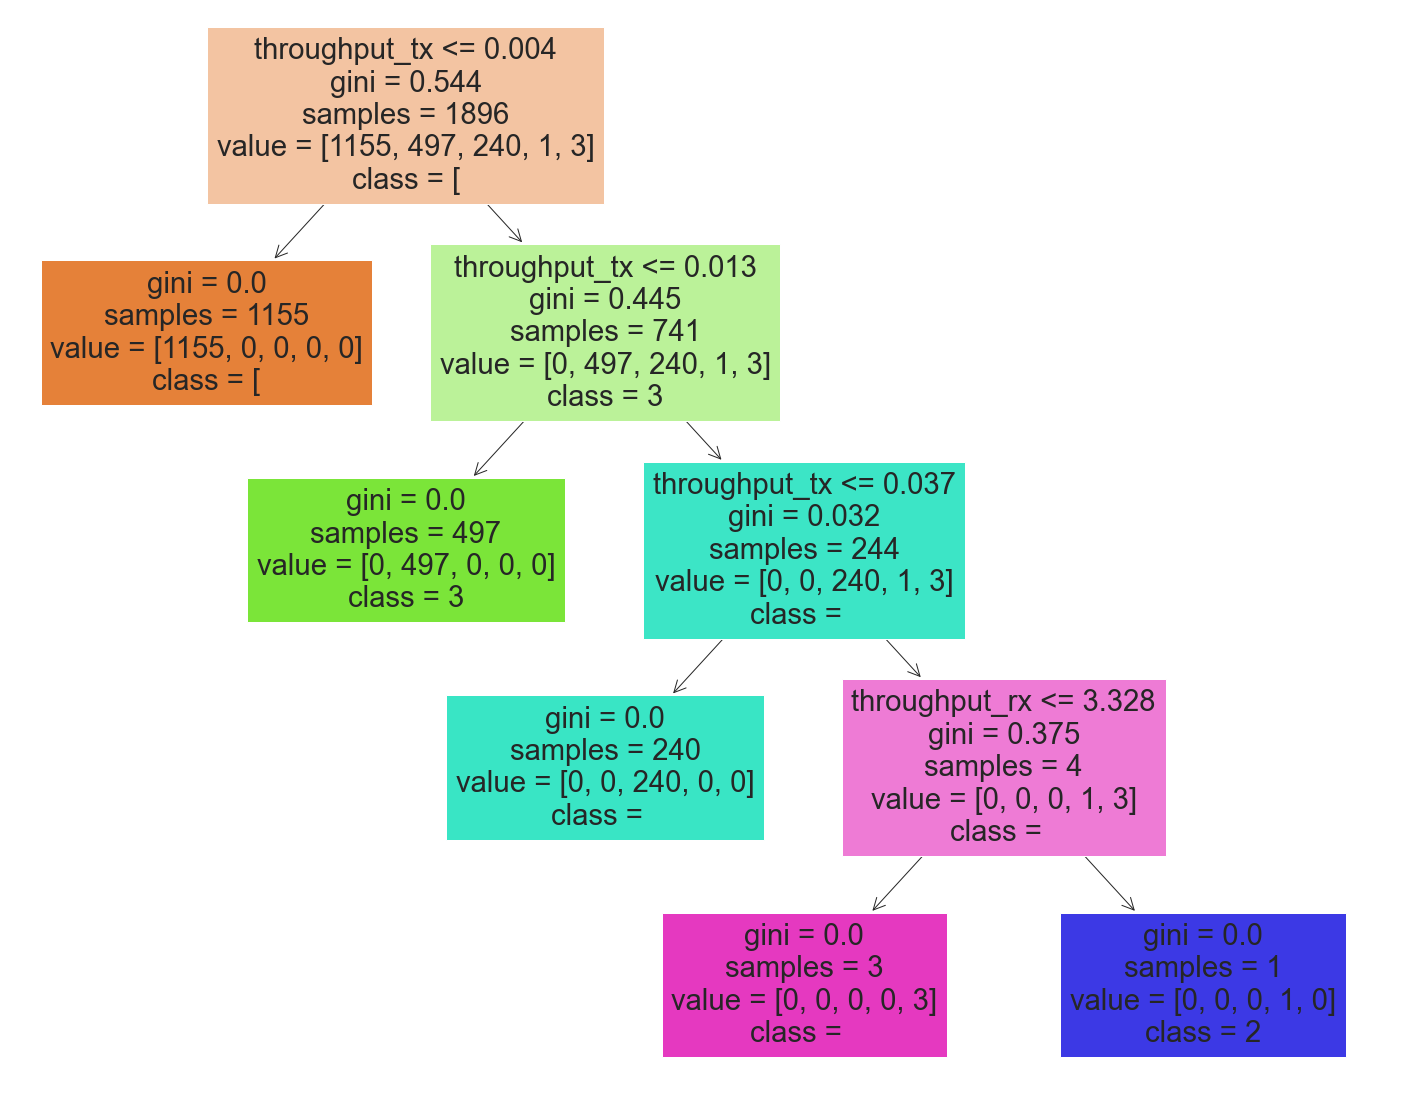

In [ ]:
fig = plt.figure(figsize =(25,20))
tree.plot_tree(arbol_qoe, feature_names =list(x.columns.values), class_names = list(y_str), filled=True)

plt.show()

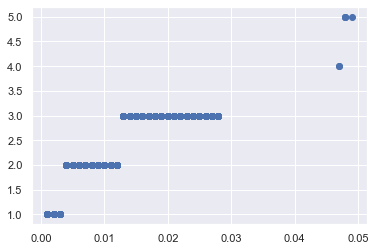

In [ ]:
y_pred = arbol_qoe.predict(x_test)

mymodel = np.poly1d(np.polyfit(x_test["throughput_tx"], y_pred, 3))
myline = np.linspace(1, 22, 100)
plt.scatter(x["throughput_tx"], y)

plt.show()



### Antes del entrenamiento

[Text(0, 0.5, 'MOS')]

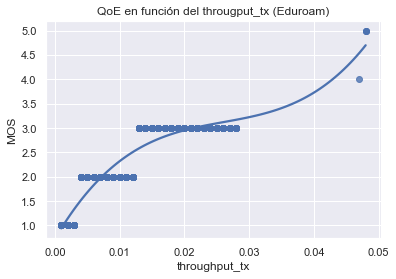

In [ ]:
plt.title("QoE en función del througput_tx (Eduroam)")
sns.regplot(x=x_train['throughput_tx'], y=y_train, data=traffic_cli_lim, order=3, ci=None).set(ylabel="MOS")

### Despues del entrenamiento


Text(0.5, 1.0, 'Estimación QoE en función del througput_tx (Eduroam)')

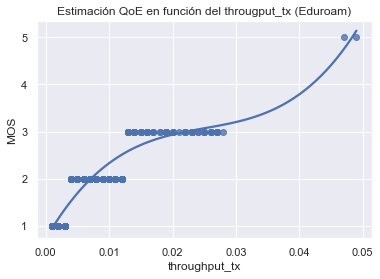

In [ ]:
sns.regplot(x=x_test['throughput_tx'], y=y_pred, data=traffic_cli_lim, order=3, ci=None).set(ylabel="MOS")
plt.title("Estimación QoE en función del througput_tx (Eduroam)")